<a href="https://colab.research.google.com/github/fabrice-camus/UNIGE-MA2a-METL-Projet-Inflection/blob/master/METL_Inflection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# METL // Projet - Morphological Inflection

author = "Fabrice Camus"

module = "METL // SP 2021-2022"

version = "1.0"

date = "14.05.2022"

description = "Given a lemma and POS, generate an inflected form, by using a seq2seq model"



#1. Clone GitHub Repository

In [17]:
repo = 'UNIGE-MA2a-METL-Projet-Inflection'

In [18]:
!git clone https://github.com/fabrice-camus/{repo}.git

Cloning into 'UNIGE-MA2a-METL-Projet-Inflection'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 84 (delta 32), reused 69 (delta 19), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [19]:
%cd {repo}

/content/UNIGE-MA2a-METL-Projet-Inflection/UNIGE-MA2a-METL-Projet-Inflection


#2. Preparing Data

In [ ]:
#!pip install -r requirements.txt

In [20]:
# MorphoInflection_dataset

import numpy as np
from numpy import array
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
from itertools import zip_longest


START_CHAR ='<'
END_CHAR ='>'
EMPTY_CHAR =''

#Pad two lists to have same length
def pad(*lists, padding=0):
    padded = [[] for _ in lists]

    for lst in zip_longest(*lists, fillvalue=padding):
        for i, elem in enumerate(lst):
            padded[i].append(elem)

    return padded

#custom collate for batch creation (dataloader)
def my_custom_collate(data):
    # data is a list of tuples
    x = [torch.tensor(d[0],dtype=torch.long) for d in data]
    y = [torch.tensor(d[1],dtype=torch.long) for d in data]
    x = pad_sequence(x, batch_first=True)
    y = pad_sequence(y, batch_first=True)
    l = [d[2] for d in data]
    msd = [d[3] for d in data]
    return x,y,l, msd


class MorphoInflectionDataset(Dataset):
  def __init__(self):
    super(MorphoInflectionDataset, self).__init__()
    self.token2id={}
    self.token2id[EMPTY_CHAR] = 0
    self.token2id[START_CHAR] = 1
    self.token2id[END_CHAR] = 2

    self.id2token=[]
    self.vocab_size=0


  # load file and extract lines
  def create_dataset(self,filename):
    #file is encoded in utf-8 
    with open(filename, encoding='utf_8') as f:
      lines = f.readlines()
      lines = [line.rstrip() for line in lines]
     
    #load raw data
    self.corpus = lines
    # create/update vocabulary and input/output in text format
    self.input, self.output, self.lemmas, self.msd = self.__build_raw_data__()
    #size of vocabulary
    self.vocab_size = len(self.token2id)

    # create a vector with token's id instead of text
    self.input_id = [self.__tokens2id__(input) for input in self.input]
    self.output_id = [self.__tokens2id__(output) for output in self.output]

    # pad to have same length    
    for i in range(len(self.input_id)):
      self.input_id[i-1], self.output_id[i-1] = pad(self.input_id[i-1], self.output_id[i-1])


  # create/update vocabulary, input and output raw data
  def __build_raw_data__(self):
  
    #start index
    index=len(self.token2id)
    lemmas=[]
    msds=[]
    input = []
    output = []
    # extract token (char) and construct all we need
    for line in self.corpus:
      
      datas=line.split('\t')
      
      lemma=datas[0]
      lemmas.append(lemma)
      msd=datas[1]
      msds.append(msd)
      inflected_form=datas[2]
      
      lemma_chars=[]
      
      #split ääkköstää into char list
      for c in lemma:
        lemma_chars.append(c)
        if c not in self.token2id:
          self.token2id[c]=index
          index+=1
      
      #idem for inflected form
      inflected_form_chars = []
      for c in inflected_form:
        inflected_form_chars.append(c)
        if c not in self.token2id:
          self.token2id[c]=index
          index+=1
      

      #extract POS-TAG : each pos-tag is a token 
      msd_tags=msd.split(',')
      msd_chars_input=[]  
      msd_chars_output=[]
      for tag in msd_tags:
        msd_chars_input.append(tag)
        msd_chars_output.append(EMPTY_CHAR)
        if tag not in self.token2id:
          self.token2id[tag]=index
          index+=1
        #pad with empty char at beginning to have a alignement POS-TAG->''
        #inflected_form_chars.insert(0,EMPTY_CHAR)
        
      #concat to construct final x and y in training data
      #input_final=[*msd_tags,*lemma_chars]
      input_final=[*lemma_chars,*msd_chars_input]
      input_final.insert(0,START_CHAR)
      input_final.append(END_CHAR)
      inflected_form_chars_final=[*inflected_form_chars,*msd_chars_output]
      inflected_form_chars_final.insert(0,START_CHAR)
      inflected_form_chars_final.append(END_CHAR)

      input.append(input_final)
      output.append(inflected_form_chars_final)


    # token list
    self.id2token = list(self.token2id.keys())
    
    return input, output, lemmas, msds 


  def __tokens2id__(self,tokens):
      return [self.token2id[token] for token in tokens]


  # len of train_data
  # must be implemented
  def __len__(self):
    return len(self.input_id) 

  # return x and y
  # must be implemented
  def __getitem__(self, idx):
    x = self.input_id[idx]
    y = self.output_id[idx]
    lemma = self.lemmas[idx]
    msd = self.msd[idx]
    #tuple (x,y)
    return x, y, lemma, msd


In [21]:
train_dataset = MorphoInflectionDataset()
train_dataset.create_dataset('./data/finnish-task1-train.txt')


In [22]:
# data sample count
len(train_dataset)

12693

In [23]:
# vocabulary
train_dataset.token2id

{'': 0,
 '-': 56,
 '<': 1,
 '>': 2,
 'a': 20,
 'aspect=PROSP': 19,
 'b': 55,
 'c': 61,
 'case=ACC': 52,
 'case=COM': 60,
 'case=FRML': 27,
 'case=GEN': 44,
 'case=IN+ABL': 46,
 'case=IN+ESS': 30,
 'case=IN+LAT': 49,
 'case=INS': 53,
 'case=NOM': 38,
 'case=ON+ABL': 39,
 'case=ON+ALL': 50,
 'case=ON+ESS': 24,
 'case=PRIV': 37,
 'case=PRT': 47,
 'case=TRANS': 40,
 'comp=CMPR': 69,
 'comp=SPRL': 70,
 'd': 36,
 'e': 29,
 'f': 59,
 'finite=NFIN': 58,
 'g': 54,
 'h': 42,
 'i': 16,
 'j': 51,
 'k': 4,
 'l': 17,
 'm': 15,
 'mood=COND': 31,
 'mood=IMP': 11,
 'mood=IND': 43,
 'mood=POT': 35,
 'mood=PURP': 62,
 'n': 8,
 'num=PL': 25,
 'num=SG': 14,
 'o': 21,
 'p': 28,
 'per=1': 32,
 'per=2': 34,
 'per=3': 13,
 'polar=POS': 10,
 'pos=ADJ': 26,
 'pos=N': 23,
 'pos=V': 9,
 'q': 71,
 'r': 41,
 's': 6,
 't': 7,
 'tense=PRS': 12,
 'tense=PST': 33,
 'u': 22,
 'v': 45,
 'voice=ACT': 18,
 'voice=PASS': 57,
 'w': 64,
 'x': 67,
 'y': 48,
 'z': 63,
 'â': 66,
 'ä': 3,
 'é': 65,
 'ö': 5,
 'ü': 68}

In [24]:
train_dataset.id2token

['',
 '<',
 '>',
 'ä',
 'k',
 'ö',
 's',
 't',
 'n',
 'pos=V',
 'polar=POS',
 'mood=IMP',
 'tense=PRS',
 'per=3',
 'num=SG',
 'm',
 'i',
 'l',
 'voice=ACT',
 'aspect=PROSP',
 'a',
 'o',
 'u',
 'pos=N',
 'case=ON+ESS',
 'num=PL',
 'pos=ADJ',
 'case=FRML',
 'p',
 'e',
 'case=IN+ESS',
 'mood=COND',
 'per=1',
 'tense=PST',
 'per=2',
 'mood=POT',
 'd',
 'case=PRIV',
 'case=NOM',
 'case=ON+ABL',
 'case=TRANS',
 'r',
 'h',
 'mood=IND',
 'case=GEN',
 'v',
 'case=IN+ABL',
 'case=PRT',
 'y',
 'case=IN+LAT',
 'case=ON+ALL',
 'j',
 'case=ACC',
 'case=INS',
 'g',
 'b',
 '-',
 'voice=PASS',
 'finite=NFIN',
 'f',
 'case=COM',
 'c',
 'mood=PURP',
 'z',
 'w',
 'é',
 'â',
 'x',
 'ü',
 'comp=CMPR',
 'comp=SPRL',
 'q']

In [25]:
# vocabulary size
len(train_dataset.token2id)

72

In [26]:
# DataLoader is useful for batching
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=my_custom_collate)

#3. Model

In [27]:
# MorphoInflection_model

#help : https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
#help : https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350#2c97
#help : https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

from torch.nn import Module
from torch.nn import Embedding
from torch.nn import LSTM
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn.functional import softmax


class morphological_inflection_seq2seq(Module):

  def __init__(self, embedding_dim, hidden_size, vocab_size):
    super(morphological_inflection_seq2seq, self).__init__()

    # vocabulary size (int)
    self.vocab_size = vocab_size

    # Embeddings dimensions (int)
    self.embedding_size = embedding_dim

    # Dimension of the NN's inside the lstm cell (int)
    self.hidden_size = hidden_size

    #--------------
    # Encoder
    #--------------
    p=0.5
    self.input_dropout = Dropout(p)

    # Embeddings : create a matrix of VxD
    # shape(vocab_size,emb_dim)
    # Embedding(72, 10)
    self.inputs_embeds = Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_size, padding_idx=0)
    

    # LSTM(10, 256)
    self.lstm_encoder = LSTM(self.embedding_size, self.hidden_size, batch_first=True, dropout=p)

    #--------------
    # Decoder
    #--------------
    
    # 72
    self.output_size = vocab_size
    self.output_dropout = Dropout(p)
    # Embeddings : create a matrix of VxD
    # (vocab_size,emb_dim)
    self.output_embeds = Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_size, padding_idx=0)
    self.lstm_decoder = LSTM(self.embedding_size, self.hidden_size, batch_first=True, dropout=p)
    #linear layer with input = hidden_size
    #out_features = voc size -> so that we can apply a softmax activation function
    #Linear(in_features=50, out_features=72, bias=True)
    self.hidden2vocab = Linear(self.hidden_size, self.vocab_size)


  def forward(self, batch, forceTeaching=False):
      
      # # x : list of n tensor (n=batch_size)
      #x[i] : 1 x sample [ 1,  9, 10,  ...,  0,  0,  0]
      x,y,_,_ = batch
      
      #batch_size x seq_len
      y_matrix = np.array(y)

      #--------------
      # Encoder part
      #--------------

      # Emmbeddings
      # torch.Size([batch_size, sequence_len, emb_dim])
      # torch.Size([64, 26, 10])
      embeds = self.input_dropout(self.inputs_embeds(x))

      # pass embeds to lstm
      # encoder_outputs : we don't care // torch.Size([batch_size, sequence_len, hidden_dim])
      # encoder_hidden_state : last hiddend state which contains our input representation
      # encoder_hidden_state: tuple(hidden state,cell state)
      # hidden_state/cell_state : torch.Size([1, batch_size, hidden dim]) // torch.Size([1, 64, 50])
      # 1 = unidirectionnel, 2 : bidir
      encoder_outputs, encoder_hidden_state = self.lstm_encoder(embeds)


      #--------------
      # Decoder part
      #--------------
      # y : list of n tensors (n=batch_size)
      #y[i] : 1 x sample [1, 0, 0,  ..., 2, 0, 0]
      # ex : 26      
      sequence_length = y_matrix.shape[1]
      batch_size= y_matrix.shape[0]

      # decoder lstm will receive hidden_state of encoder
      hidden_state = encoder_hidden_state
      # tensor for whole outputs --> contains id of predicted inflected form
      # shape [seq_len, batch_size, self.vocab_size] //torch.Size([26, 64,72])
      outputs = torch.zeros(sequence_length,batch_size,self.vocab_size)

      #one char
      #shape(batch_size,1)     
      token=y[:,[0]]
      
      # for each char in y, call lstm to predict next char
      # teach forcing --> give to next loop gold char (from y) and not predicted char
      for i in range(1, sequence_length):

        embeds = self.output_dropout(self.output_embeds(token) )
        #LSTM layer
        #output shape :[batch_size, seq_len, hidden size] torch.Size([64, 1, 50])
        output, hidden_state = self.lstm_decoder(embeds, hidden_state)
        
        
        #output : prediction of next token 
        #shape [batch_size,seq_len, vocab_size] // torch.Size([64, 1, 72])
        prediction = self.hidden2vocab(output)

        #shape [batch_size, vocab_size] // torch.Size([64, 72])
        prediction = prediction.squeeze(1)

        #torch.Size([64,72])
        prediction_probs = softmax(prediction,1)
       
        outputs[i]=prediction_probs

        # teacher forcing : next input in lstm isn't the predicted token, but the gold token (from y)
        if forceTeaching:
          token = y[:,[i]] 
        else:
          #next token is the predicted token
          token = torch.argmax(prediction_probs,1).view(prediction_probs.shape[0],1)
          
         


      # -->seq_len, batch_size, self.vocab_size
      outputs=torch.moveaxis(outputs,0,2)
      return outputs


#4. Training

In [ ]:
##Training

from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import time
from torch.nn import CrossEntropyLoss

# Model
emb_dim=10
hidden_dim=256
morpho_inflection_model = morphological_inflection_seq2seq(emb_dim, hidden_dim, train_dataset.vocab_size)

# Optimizer
optimizer = SGD(morpho_inflection_model.parameters(), lr=0.1)

# Loss
cross_entropy_loss = CrossEntropyLoss()

# Hyper-params
num_epochs = 1000

# Metrics
losses_epoch_train = []



# Loop
for epoch in range(num_epochs):
  
  morpho_inflection_model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  batch_number=1
  
  for batch in train_loader:
    print(f'Epoch ({epoch+1}/{num_epochs}) -  Batch ({batch_number}/{len(train_loader)}])')   

    #batch --> tuples(x,y)
    # "shape" : (batch_size,2)
    # x : list of n tensor (n=batch_size)
    #x[i] : 1 x sample [ 1,  9, 10,  ...,  0,  0,  0]
    x, y,_,_ = batch

    # call of forward function and get the output
    # shape [batch_size,vocab_size,seq_len] //torch.Size([64, 72, 26])
    y_scores = morpho_inflection_model(batch=batch,forceTeaching=True)

    
    # compute loss
    # input (y_scores) must be [batch_size,number_of_classes,seq_len]
    # target (y) must be [batch_size,seq_len]
    loss = cross_entropy_loss(y_scores, y)

    epoch_loss += loss.item()

  
    #backpropagation   
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    batch_number+=1
    
    

  losses_epoch_train.append(epoch_loss/len(train_loader))
  
  morpho_inflection_model.eval()
  torch.save(morpho_inflection_model, './model/model.pth')
  np.save('./model/losses_epoch_train.npy', losses_epoch_train)
  

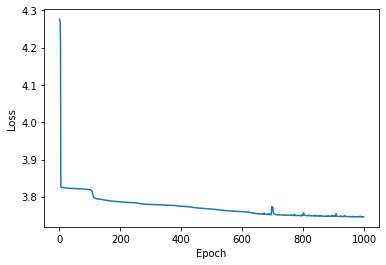

In [28]:
import numpy as np
import matplotlib.pyplot as plt
losses_epoch_train=np.load('./model/losses_epoch_train.npy')
num_epochs=1000

plt.plot(range(num_epochs),losses_epoch_train, label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('./model/loss.png')
plt.show()

#5. Evaluation

In [29]:
from torch import argmax

#train_dataset.create_dataset('./data/finnish-task1-train.txt')
#train_dataset.create_dataset('./data/finnish-task1-dev')
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=my_custom_collate)

emb_dim=10
hidden_dim=256
morpho_inflection_model = morphological_inflection_seq2seq(emb_dim, hidden_dim, train_dataset.vocab_size)

morpho_inflection_model= torch.load('./model/model.pth')
morpho_inflection_model.eval()

#f = open('./data/finnish-task1-dev-guess', 'w')
f = open('./data/finnish-task1-train-guess', 'w')
    

for batch in train_loader:
  x, y,l,m = batch

  #torch.Size([64, 72, 26])
  y_scores = morpho_inflection_model(batch=batch,forceTeaching=False)
    
  prediction_string=''
  for sample in range(len(x)):
    #y_scores for one sample
    y_sample=y_scores[sample]

    prediction_id=torch.argmax(y_sample,0)
    #print(prediction_id)
    prediction_array=[train_dataset.id2token[p] for p in prediction_id]
    prediction_string=''.join(prediction_array)
    if prediction_string=='':
      prediction_string='NULL'
    f.write(l[sample]+'\t'+m[sample]+'\t'+prediction_string+'\n')

  
f.close()  


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [30]:
!python2.7 evalm.py --golden=./data/finnish-task1-train.txt --guesses=./data/finnish-task1-train-guess

N
Accuracy: 0.0
Mean Levenshtein: 10.3535002008
Mean Normalized Levenshtein: 0.804215442593
Mean Reciprocal Rank: 0.0

ADJ
Accuracy: 0.0
Mean Levenshtein: 9.57352941176
Mean Normalized Levenshtein: 0.81156526334
Mean Reciprocal Rank: 0.0

V
Accuracy: 0.0
Mean Levenshtein: 9.29252525253
Mean Normalized Levenshtein: 0.815253453371
Mean Reciprocal Rank: 0.0

Aggregate
Accuracy: 0.0
Mean Levenshtein: 9.92302844087
Mean Normalized Levenshtein: 0.808677532295
Mean Reciprocal Rank: 0.0


In [31]:
!python2.7 evalm.py --golden=./data/finnish-task1-dev --guesses=./data/finnish-task1-dev-guess

N
Accuracy: 0.0
Mean Levenshtein: 10.5088819227
Mean Normalized Levenshtein: 0.801755787863
Mean Reciprocal Rank: 0.0

ADJ
Accuracy: 0.0
Mean Levenshtein: 8.83333333333
Mean Normalized Levenshtein: 0.754135524969
Mean Reciprocal Rank: 0.0

V
Accuracy: 0.0
Mean Levenshtein: 9.42314049587
Mean Normalized Levenshtein: 0.838341760564
Mean Reciprocal Rank: 0.0

Aggregate
Accuracy: 0.0
Mean Levenshtein: 10.0600750939
Mean Normalized Levenshtein: 0.814534376111
Mean Reciprocal Rank: 0.0
